# Robot Calibration

## Nominal Robot
- A nominal robot model:
    - Represents what the robot manufacturer intended as a kinematic model
    - Is mathematically ideal

In [1]:
from pybotics.robot import Robot
from pybotics.predefined_models import ur10

nominal_robot = Robot.from_parameters(ur10())

In [4]:
import pandas as pd

def display_robot_kinematics(robot: Robot):
    df = pd.DataFrame(robot.kinematic_chain.matrix)
    df.columns = ["alpha", "a", "theta", "d"]
    display(df)

display_robot_kinematics(nominal_robot)

,alpha,a,theta,d
0,0.000000,0.0,0.000000,118.0
1,1.570796,0.0,3.141593,0.0
2,0.000000,612.7,0.000000,0.0
3,0.000000,571.6,0.000000,163.9
4,-1.570796,0.0,0.000000,115.7
5,1.570796,0.0,3.141593,92.2


## *Real* Robots
- *Real* robots do not conform perfectly to the nominal parameters
- Small errors in the robot model can generate large errors in Cartesian position
- Sources of errors include, but are not limited to:
    - Kinematic errors
        - Mechanical tolerances
        - Angle offsets
    - Non-kinematic errors
        - Joint stiffness
        - Gravity
        - Temperature
        - Friction

In [5]:
import numpy as np
from copy import deepcopy

real_robot = deepcopy(nominal_robot)

# let's pretend our real robot has small joint offsets
# in real life, this would be a joint mastering issue (level-1 calibration)
# https://en.wikipedia.org/wiki/Robot_calibration
for link in real_robot.kinematic_chain.links:
    link.theta += np.random.uniform(
        low=np.deg2rad(-0.1),
        high=np.deg2rad(0.1)
    )

display_robot_kinematics(real_robot)

,alpha,a,theta,d
0,0.000000,0.0,-0.001509,118.0
1,1.570796,0.0,3.142406,0.0
2,0.000000,612.7,-0.000711,0.0
3,0.000000,571.6,0.000512,163.9
4,-1.570796,0.0,0.000921,115.7
5,1.570796,0.0,3.142297,92.2


## Get *Real* (aka Measured) Poses
- In real life, these poses would be measured using metrology equipment (e.g., laser tracker, CMM)

In [6]:
joints = []
positions = []
for i in range(1000):
    q = real_robot.random_joints()
    pose = real_robot.fk(q)
    
    joints.append(q)
    positions.append(pose[:-1,-1])

In [7]:
pd.DataFrame(joints).describe()

,0,1,2,3,4,5
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.047702,0.051001,-0.079480,0.030139,-0.011763,0.020381
std,1.799804,1.808733,1.810610,1.790227,1.871819,1.824008
min,-3.105361,-3.138609,-3.130845,-3.139920,-3.139458,-3.123646
25%,-1.507057,-1.508333,-1.699087,-1.530983,-1.638796,-1.486191
50%,0.093303,0.067023,-0.058198,0.062386,-0.053413,-0.006788
75%,1.644339,1.583571,1.449470,1.555099,1.685396,1.637713
max,3.131182,3.137136,3.137420,3.138143,3.130878,3.141305


In [8]:
pd.DataFrame(positions, columns=['x','y','z']).describe()

,x,y,z
count,1000.000000,1000.000000,1000.000000
mean,2.274330,5.645392,87.663492
std,456.735568,436.861813,588.017371
min,-1249.973263,-1253.078191,-1169.044358
25%,-247.695339,-233.231942,-339.937742
50%,1.531032,3.245680,72.722988
75%,252.070739,253.222272,509.946999
max,1276.159195,1252.807061,1395.080946


## Split Calibration and Validation Measures
- A portion of the measured configurations and positions should be set aside for validation after calibration (i.e., optimization)
    - This is to prevent/check the optimized model for overfitting

In [10]:
from sklearn.model_selection import train_test_split
split = train_test_split(joints, positions, test_size=0.3)

train_joints = split[0]
test_joints = split[1]

train_positions = split[2]
test_positions = split[3]

## Get Nominal Position Errors
- These nominal model is our starting point for calibration
- The errors are in millimetres 

In [11]:
from pybotics.optimization import compute_absolute_errors

nominal_errors = compute_absolute_errors(
    qs=test_joints,
    positions=test_positions,
    robot=nominal_robot
)

display(pd.Series(nominal_errors).describe())

count    300.000000
mean       0.961342
std        0.469048
min        0.129001
25%        0.625228
50%        0.843774
75%        1.303911
max        2.143065
dtype: float64

## Calibration

In [12]:
from pybotics.optimization import OptimizationHandler

# init calibration handler
handler = OptimizationHandler(nominal_robot)

# set handler to solve for theta parameters
kc_mask_matrix = np.zeros_like(nominal_robot.kinematic_chain.matrix, dtype=bool)
kc_mask_matrix[:,2] = True
display(kc_mask_matrix)

handler.kinematic_chain_mask = kc_mask_matrix.ravel()

array([[False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False]])

In [13]:
from scipy.optimize import least_squares
from pybotics.optimization import optimize_accuracy

# run optimization
result = least_squares(
    fun=optimize_accuracy,
    x0=handler.generate_optimization_vector(),
    args=(handler, train_joints, train_positions),
    verbose=2
)  # type: scipy.optimize.OptimizeResult

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.1063e+02                                    4.23e+05    
       1              8         7.0118e+01      3.41e+02       1.08e-03       1.54e+05    
       2              9         2.2908e+01      4.72e+01       2.17e-03       7.89e+04    
       3             11         2.5290e-01      2.27e+01       1.08e-03       2.75e+03    
       4             14         8.2830e-02      1.70e-01       1.36e-04       2.62e+03    
       5             16         3.5286e-02      4.75e-02       6.78e-05       2.42e+03    
       6             17         2.1245e-03      3.32e-02       6.78e-05       6.68e+02    
       7             19         1.5761e-03      5.48e-04       3.39e-05       6.40e+02    
       8             21         3.1752e-04      1.26e-03       8.47e-06       2.27e+02    
       9             23         1.2419e-04      1.93e-04       4.24e-06       1.75e+02    

## Results
- A calibrated robot model is never perfect in real life
    - The goal is often to reduce the max error under a desired threshold

In [14]:
calibrated_robot = handler.robot
calibrated_errors = compute_absolute_errors(
    qs=test_joints,
    positions=test_positions,
    robot=calibrated_robot
)

display(pd.Series(calibrated_errors).describe())

count    3.000000e+02
mean     2.129127e-06
std      6.416880e-07
min      3.197510e-07
25%      1.697060e-06
50%      2.146973e-06
75%      2.609021e-06
max      3.525018e-06
dtype: float64

Text(0, 0.5, 'Frequency')

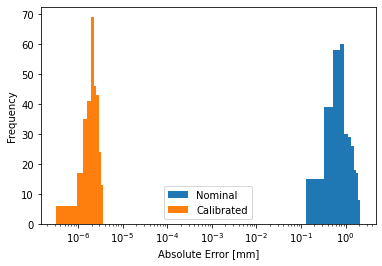

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.xscale("log")
plt.hist(nominal_errors, color="C0", label="Nominal")
plt.hist(calibrated_errors, color="C1", label="Calibrated")

plt.legend()
plt.xlabel("Absolute Error [mm]")
plt.ylabel("Frequency")